# News Clustering POC

This notebook demonstrates clustering news using:
1. **OpenAI Embeddings** - to convert text into vector representations
2. **UMAP** - for dimensionality reduction
3. **HDBSCAN** - for density-based clustering

## Setup

In [62]:
import json
import os
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from openai import OpenAI

pio.renderers.default = "browser"

load_dotenv()

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## 1. Load News Data

In [63]:
# Load news data from JSON file
with open("/Users/wnowogor/PycharmProjects/PythonProject/NewsFinder/news.json", "r", encoding="utf-8") as f:
    data = json.load(f)

news_items = data["news"]
print(f"Loaded {len(news_items)} news items")

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(news_items)
df.head()

Loaded 24 news items


,title,summary,content,keywords,category,sentiment,importance,entities,source_video_id,source_video_title,source_video_url,source_channel,extracted_at
0,EU Introduces 'EU Inc.' to Boost Startups,The European Union is launching a new legal fr...,"The European Commission, led by Ursula Vanderl...","[EU Inc., startups, European Union, Ursula Van...",Business,positive,high,"[Ursula Vanderlayan, European Union]",jWSSPpRIiOg,Europe Inc. as a Response to U.S. Pressure,https://www.youtube.com/watch?v=jWSSPpRIiOg,@GoodTimesBadTimes,2026-01-30T00:23:32.729999
1,EU's Investment Union to Mobilize €10 Trillion...,The European Commission is working on an inves...,Ursula Vanderlayan confirmed that the European...,"[investment union, savings, European market]",Business,positive,high,"[Ursula Vanderlayan, European Commission]",jWSSPpRIiOg,Europe Inc. as a Response to U.S. Pressure,https://www.youtube.com/watch?v=jWSSPpRIiOg,@GoodTimesBadTimes,2026-01-30T00:23:32.730016
2,EU Shifts Energy Policy to Include Nuclear Power,The European Union is reconsidering its energy...,Ursula Vanderlayan announced that the European...,"[energy policy, nuclear power, European Union]",Politics,neutral,medium,"[Ursula Vanderlayan, Germany, European Union]",jWSSPpRIiOg,Europe Inc. as a Response to U.S. Pressure,https://www.youtube.com/watch?v=jWSSPpRIiOg,@GoodTimesBadTimes,2026-01-30T00:23:32.730021
3,Canada and EU Strengthen Ties Amid U.S. Tensions,Canada and the European Union are strengthenin...,"In light of recent tensions with the U.S., par...","[Canada, European Union, Greenland, Mark Carney]",Politics,positive,high,"[Mark Carney, Canada, European Union]",jWSSPpRIiOg,Europe Inc. as a Response to U.S. Pressure,https://www.youtube.com/watch?v=jWSSPpRIiOg,@GoodTimesBadTimes,2026-01-30T00:23:32.730025
4,EU and India Near Major Free Trade Agreement,The European Union is finalizing a significant...,The European Union is in the final stages of n...,"[free trade agreement, India, European Union]",Business,positive,high,"[European Union, India]",jWSSPpRIiOg,Europe Inc. as a Response to U.S. Pressure,https://www.youtube.com/watch?v=jWSSPpRIiOg,@GoodTimesBadTimes,2026-01-30T00:23:32.730027


In [64]:
# Examine the data structure
print("Columns:", df.columns.tolist())
print("\nCategories distribution:")
print(df["category"].value_counts())
print("\nSentiment distribution:")
print(df["sentiment"].value_counts())

Columns: ['title', 'summary', 'content', 'keywords', 'category', 'sentiment', 'importance', 'entities', 'source_video_id', 'source_video_title', 'source_video_url', 'source_channel', 'extracted_at']

Categories distribution:
category
Politics                   15
Business                    4
Economics                   2
History                     1
International Relations     1
Technology                  1
Name: count, dtype: int64

Sentiment distribution:
sentiment
negative    11
positive     8
neutral      5
Name: count, dtype: int64


## 2. Prepare Text for Embedding

We'll combine title, summary, and content to create a comprehensive text representation for each news item.

In [65]:
def prepare_text_for_embedding(row: pd.Series) -> str:
    """Combine relevant fields into a single text for embedding."""
    parts = [
        f"Title: {row['title']}",
        f"Summary: {row['summary']}",
        f"Content: {row['content']}",
        f"Keywords: {', '.join(row['keywords'])}",
        f"Category: {row['category']}",
    ]
    return "\n".join(parts)


df["text_for_embedding"] = df.apply(prepare_text_for_embedding, axis=1)

print(df["text_for_embedding"].iloc[0][:500] + "...")

Title: EU Introduces 'EU Inc.' to Boost Startups
Summary: The European Union is launching a new legal framework called 'EU Inc.' aimed at simplifying the establishment and scaling of startups across member states. This initiative seeks to create a unified company structure to enhance competitiveness against the U.S. and China.
Content: The European Commission, led by Ursula Vanderlayan, announced the introduction of 'EU Inc.', a new pan-European legal standard designed to facilitate the establis...


## 3. Generate OpenAI Embeddings

In [66]:
def get_embeddings(texts: list[str], model: str = "text-embedding-3-small") -> list[list[float]]:
    """Get embeddings for a list of texts using OpenAI API."""
    response = client.embeddings.create(
        input=texts,
        model=model
    )
    return [item.embedding for item in response.data]


# Generate embeddings for all news items
print("Generating embeddings...")
texts = df["text_for_embedding"].tolist()
embeddings = get_embeddings(texts)

# Convert to numpy array
embeddings_array = np.array(embeddings)
print(f"Embeddings shape: {embeddings_array.shape}")

Generating embeddings...
Embeddings shape: (24, 1536)


In [67]:
# Save embeddings for later use (optional)
np.save("news_embeddings.npy", embeddings_array)
print("Embeddings saved to news_embeddings.npy")

Embeddings saved to news_embeddings.npy


## 4. Dimensionality Reduction with UMAP

UMAP (Uniform Manifold Approximation and Projection) is effective for preserving both local and global structure in the data.

In [68]:
import umap

# UMAP parameters
# n_neighbors: controls how UMAP balances local vs global structure
# min_dist: controls how tightly UMAP packs points together
# n_components: number of dimensions to reduce to

# First, reduce to a moderate number of dimensions for clustering
umap_reducer_clustering = umap.UMAP(
    n_neighbors=5,
    n_components=10,  # Reduce to 10D for clustering
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

print("Reducing dimensionality for clustering...")
embeddings_reduced_clustering = umap_reducer_clustering.fit_transform(embeddings_array)
print(f"Reduced embeddings shape: {embeddings_reduced_clustering.shape}")

Reducing dimensionality for clustering...
Reduced embeddings shape: (24, 10)


/Users/wnowogor/PycharmProjects/PythonProject/NewsFinder/.venv/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## 5. Clustering with HDBSCAN

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is excellent for:
- Finding clusters of varying densities
- Automatically determining the number of clusters
- Identifying noise/outliers

In [69]:
import hdbscan

# HDBSCAN parameters
# min_cluster_size: minimum number of samples in a cluster
# min_samples: how conservative the clustering should be
# cluster_selection_epsilon: distance threshold for cluster membership

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,  # Small value since we have limited data
    min_samples=1,
    metric="euclidean",
    cluster_selection_method="eom",  # Excess of Mass
    prediction_data=True
)

print("Clustering...")
cluster_labels = clusterer.fit_predict(embeddings_reduced_clustering)

df["cluster"] = cluster_labels

# Cluster statistics
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"\nCluster distribution:")
print(df["cluster"].value_counts().sort_index())

Clustering...
Number of clusters found: 5
Number of noise points: 0

Cluster distribution:
cluster
0    6
1    5
2    3
3    4
4    6
Name: count, dtype: int64


## 6. Visualize Clusters

In [70]:
# First, reduce to 2D for visualization
umap_reducer_viz = umap.UMAP(
    n_neighbors=5,
    n_components=2,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

print("Reducing to 2D for visualization...")
embeddings_2d = umap_reducer_viz.fit_transform(embeddings_array)
df["umap_x"] = embeddings_2d[:, 0]
df["umap_y"] = embeddings_2d[:, 1]

# Create interactive scatter plot with Plotly
df["cluster_label"] = df["cluster"].apply(lambda x: f"Cluster {x}" if x >= 0 else "Noise")

fig = px.scatter(
    df,
    x="umap_x",
    y="umap_y",
    color="cluster_label",
    hover_data=["title", "category", "source_channel"],
    title="News Clustering Results (UMAP + HDBSCAN)",
    labels={"umap_x": "UMAP Dimension 1", "umap_y": "UMAP Dimension 2"},
    width=900,
    height=600
)

fig.update_traces(marker=dict(size=12))
fig.update_layout(legend_title="Cluster")

# Save to HTML and display (workaround for nbformat issues)
fig.write_html("clustering/cluster_visualization.html")
print("Interactive plot saved to cluster_visualization.html")

# Try to display inline, fall back to static image if needed
try:
    fig.show()
except ValueError:
    # Fallback: display as static image
    fig.show(renderer="png")

Reducing to 2D for visualization...
Interactive plot saved to cluster_visualization.html


/Users/wnowogor/PycharmProjects/PythonProject/NewsFinder/.venv/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [71]:
# Visualize by original category for comparison
fig2 = px.scatter(
    df,
    x="umap_x",
    y="umap_y",
    color="category",
    hover_data=["title", "cluster_label", "source_channel"],
    title="News by Original Category (for comparison)",
    labels={"umap_x": "UMAP Dimension 1", "umap_y": "UMAP Dimension 2"},
    width=900,
    height=600
)

fig2.update_traces(marker=dict(size=12))
fig2.write_html("clustering/category_visualization.html")
print("Interactive plot saved to category_visualization.html")
fig2.show()

Interactive plot saved to category_visualization.html


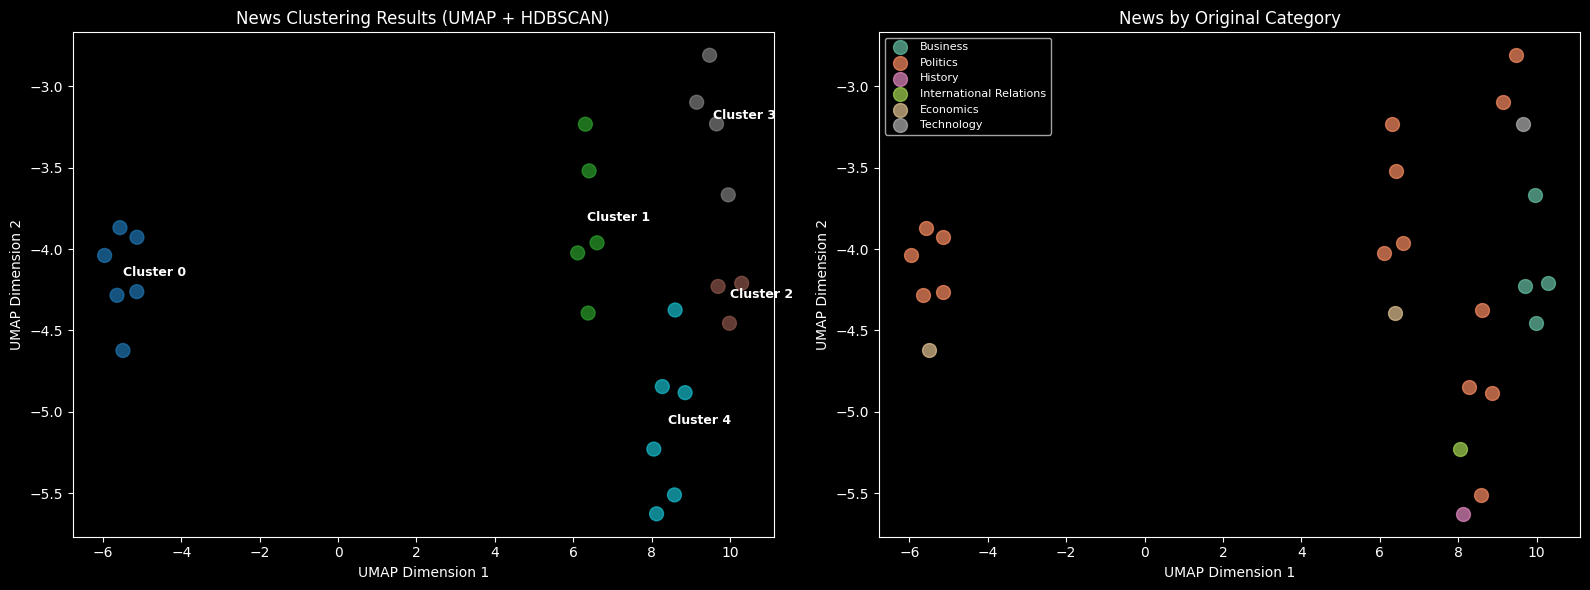

Static plot saved to clustering_visualization.png


In [72]:
# Alternative: Matplotlib visualization (always works)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: By cluster
scatter1 = axes[0].scatter(
    df["umap_x"], 
    df["umap_y"], 
    c=df["cluster"], 
    cmap="tab10", 
    s=100, 
    alpha=0.7
)
axes[0].set_xlabel("UMAP Dimension 1")
axes[0].set_ylabel("UMAP Dimension 2")
axes[0].set_title("News Clustering Results (UMAP + HDBSCAN)")

# Add cluster labels
for cluster_id in df["cluster"].unique():
    cluster_df = df[df["cluster"] == cluster_id]
    centroid_x = cluster_df["umap_x"].mean()
    centroid_y = cluster_df["umap_y"].mean()
    label = f"Cluster {cluster_id}" if cluster_id >= 0 else "Noise"
    axes[0].annotate(label, (centroid_x, centroid_y), fontsize=9, weight='bold')

# Plot 2: By category
categories = df["category"].unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(categories)))
for i, cat in enumerate(categories):
    cat_df = df[df["category"] == cat]
    axes[1].scatter(cat_df["umap_x"], cat_df["umap_y"], c=[colors[i]], label=cat, s=100, alpha=0.7)

axes[1].set_xlabel("UMAP Dimension 1")
axes[1].set_ylabel("UMAP Dimension 2")
axes[1].set_title("News by Original Category")
axes[1].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.savefig("clustering/clustering_visualization.png", dpi=150)
plt.show()
print("Static plot saved to clustering_visualization.png")

## 7. Analyze Clusters

In [73]:
# Display news items in each cluster
for cluster_id in sorted(df["cluster"].unique()):
    cluster_df = df[df["cluster"] == cluster_id]
    
    if cluster_id == -1:
        print(f"\n{'='*80}")
        print(f"NOISE POINTS ({len(cluster_df)} items)")
        print(f"{'='*80}")
    else:
        print(f"\n{'='*80}")
        print(f"CLUSTER {cluster_id} ({len(cluster_df)} items)")
        print(f"{'='*80}")
    
    for _, row in cluster_df.iterrows():
        print(f"\n  - {row['title']}")
        print(f"    Category: {row['category']} | Sentiment: {row['sentiment']}")
        print(f"    Source: {row['source_channel']}")


CLUSTER 0 (6 items)

  - Turkey's First Fully-Fledged Aircraft Carrier Under Construction
    Category: Politics | Sentiment: positive
    Source: @GoodTimesBadTimes

  - Erdogan's Political Power Faces Erosion Amid Economic Crisis
    Category: Politics | Sentiment: negative
    Source: @GoodTimesBadTimes

  - Potential Constitutional Changes to Extend Erdoğan's Rule
    Category: Politics | Sentiment: negative
    Source: @GoodTimesBadTimes

  - Arrest of Ekrem İmamoğlu Raises Concerns Over Political Oppression
    Category: Politics | Sentiment: negative
    Source: @GoodTimesBadTimes

  - Turkey's Assertive Foreign Policy and Military Expansion
    Category: Politics | Sentiment: positive
    Source: @GoodTimesBadTimes

  - Economic Challenges and Inflation in Turkey
    Category: Economics | Sentiment: negative
    Source: @GoodTimesBadTimes

CLUSTER 1 (5 items)

  - High Human Cost of Russian Territorial Gains in Ukraine
    Category: Politics | Sentiment: negative
    Source: @

In [74]:
# Extract common themes/keywords per cluster
from collections import Counter


def get_cluster_keywords(cluster_df: pd.DataFrame, top_n: int = 10) -> list[tuple[str, int]]:
    """Extract most common keywords from a cluster."""
    all_keywords = []
    for keywords in cluster_df["keywords"]:
        all_keywords.extend(keywords)
    return Counter(all_keywords).most_common(top_n)


def get_cluster_entities(cluster_df: pd.DataFrame, top_n: int = 10) -> list[tuple[str, int]]:
    """Extract most common entities from a cluster."""
    all_entities = []
    for entities in cluster_df["entities"]:
        all_entities.extend(entities)
    return Counter(all_entities).most_common(top_n)


print("Cluster Analysis - Top Keywords and Entities")
print("=" * 60)

for cluster_id in sorted(df["cluster"].unique()):
    if cluster_id == -1:
        continue
        
    cluster_df = df[df["cluster"] == cluster_id]
    keywords = get_cluster_keywords(cluster_df, top_n=5)
    entities = get_cluster_entities(cluster_df, top_n=5)
    
    print(f"\nCluster {cluster_id}:")
    print(f"  Top Keywords: {keywords}")
    print(f"  Top Entities: {entities}")
    print(f"  Categories: {cluster_df['category'].value_counts().to_dict()}")

Cluster Analysis - Top Keywords and Entities

Cluster 0:
  Top Keywords: [('Turkey', 4), ('economic crisis', 2), ('aircraft carrier', 1), ('military', 1), ('Erdogan', 1)]
  Top Entities: [('Erdoğan', 4), ('Turkey', 3), ('Justice and Development Party (AK)', 1), ('Ekrem İmamoğlu', 1), ('Syria', 1)]
  Categories: {'Politics': 5, 'Economics': 1}

Cluster 1:
  Top Keywords: [('Ukraine', 4), ('Russia', 1), ('war casualties', 1), ('Russian economy', 1), ('oil revenues', 1)]
  Top Entities: [('Ukraine', 3), ('Russia', 2), ('Bloomberg', 1), ('European Union', 1), ('Belgium', 1)]
  Categories: {'Politics': 4, 'Economics': 1}

Cluster 2:
  Top Keywords: [('European Union', 2), ('EU Inc.', 1), ('startups', 1), ('Ursula Vanderlayan', 1), ('investment union', 1)]
  Top Entities: [('Ursula Vanderlayan', 2), ('European Union', 2), ('European Commission', 1), ('India', 1)]
  Categories: {'Business': 3}

Cluster 3:
  Top Keywords: [('energy policy', 1), ('nuclear power', 1), ('European Union', 1), ('Tr

## 8. Cluster Probabilities (Soft Clustering)

In [75]:
# HDBSCAN provides cluster membership probabilities
df["cluster_probability"] = clusterer.probabilities_

# Show items with lower confidence in their cluster assignment
print("Items with cluster assignment probability < 0.5:")
low_confidence = df[df["cluster_probability"] < 0.5][["title", "cluster", "cluster_probability"]]
if len(low_confidence) > 0:
    for _, row in low_confidence.iterrows():
        print(f"  - {row['title'][:60]}... (Cluster: {row['cluster']}, Prob: {row['cluster_probability']:.2f})")
else:
    print("  All items have high confidence assignments.")

Items with cluster assignment probability < 0.5:
  All items have high confidence assignments.


## 9. Export Results

In [76]:
# Export clustered results to JSON
output_data = {
    "clustering_params": {
        "embedding_model": "text-embedding-3-small",
        "umap_n_neighbors": 5,
        "umap_n_components_clustering": 10,
        "hdbscan_min_cluster_size": 2,
        "hdbscan_min_samples": 1
    },
    "num_clusters": n_clusters,
    "num_noise_points": n_noise,
    "clusters": {}
}

for cluster_id in sorted(df["cluster"].unique()):
    cluster_df = df[df["cluster"] == cluster_id]
    cluster_key = f"cluster_{cluster_id}" if cluster_id >= 0 else "noise"
    
    output_data["clusters"][cluster_key] = {
        "count": len(cluster_df),
        "items": cluster_df[["title", "summary", "category", "sentiment", "source_video_title", "cluster_probability"]].to_dict(orient="records")
    }

with open("clustering/clustered_news.json", "w", encoding="utf-8") as f:
    json.dump(output_data, f, indent=2, ensure_ascii=False)

print("Results saved to clustered_news.json")

Results saved to clustered_news.json


## 10. Parameter Tuning Exploration

Different parameters can significantly affect clustering results. Here's how to explore different configurations.

In [77]:
# Experiment with different HDBSCAN parameters
param_configs = [
    {"min_cluster_size": 2, "min_samples": 1},
    {"min_cluster_size": 3, "min_samples": 1},
    {"min_cluster_size": 2, "min_samples": 2},
    {"min_cluster_size": 3, "min_samples": 2},
]

print("Parameter Exploration Results:")
print("=" * 60)

for params in param_configs:
    temp_clusterer = hdbscan.HDBSCAN(
        min_cluster_size=params["min_cluster_size"],
        min_samples=params["min_samples"],
        metric="euclidean",
        cluster_selection_method="eom"
    )
    temp_labels = temp_clusterer.fit_predict(embeddings_reduced_clustering)
    
    temp_n_clusters = len(set(temp_labels)) - (1 if -1 in temp_labels else 0)
    temp_n_noise = list(temp_labels).count(-1)
    
    print(f"\nmin_cluster_size={params['min_cluster_size']}, min_samples={params['min_samples']}:")
    print(f"  Clusters: {temp_n_clusters}, Noise: {temp_n_noise}")

Parameter Exploration Results:

min_cluster_size=2, min_samples=1:
  Clusters: 5, Noise: 0

min_cluster_size=3, min_samples=1:
  Clusters: 5, Noise: 0

min_cluster_size=2, min_samples=2:
  Clusters: 5, Noise: 0

min_cluster_size=3, min_samples=2:
  Clusters: 5, Noise: 0


## Summary

This POC demonstrates:

1. **Loading news data** from the yt_channel_news_extractor output
2. **Generating embeddings** using OpenAI's text-embedding-3-small model
3. **Dimensionality reduction** with UMAP (to 10D for clustering, 2D for visualization)
4. **Clustering** with HDBSCAN to find natural groupings
5. **Visualization** with interactive Plotly scatter plots
6. **Analysis** of cluster contents, keywords, and entities

### Next Steps

- Fine-tune UMAP and HDBSCAN parameters based on your data
- Experiment with different embedding models (e.g., text-embedding-3-large)
- Add cluster labeling using LLM summarization
- Implement incremental clustering for new articles
- Build a pipeline for automatic cluster detection and reporting